In [50]:

# import needed modules
import time
import datetime
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
start = datetime.date(2010,1,1)
end = datetime.date.today()



In [51]:
# ticker_info = yf.Ticker("9984.T")
# hist = ticker_info.history(period="max")
# VYM VTI VNQI VNQ
# tickerList = ['VT','BND','','GLD','','','VIG','']
tickerList = ['VT','BND','GLD','VIG','PDBC','VNQ']
data = yf.download(tickerList, start=start, end=end)["Adj Close"]
data

[*********************100%***********************]  6 of 6 completed


,BND,GLD,PDBC,VIG,VNQ,VT
Date,,,,,,
2009-12-31,55.724014,107.309998,NaN,36.430309,27.823154,32.810135
2010-01-04,55.787827,109.800003,NaN,36.888996,27.704998,33.579185
2010-01-05,55.950951,109.699997,NaN,36.865669,27.673901,33.678162
2010-01-06,55.929672,111.510002,NaN,36.888996,27.624149,33.845695
2010-01-07,55.887089,110.820000,NaN,37.075592,27.922667,33.716244
...,...,...,...,...,...,...
2022-05-19,76.089996,171.910004,18.900000,145.210007,94.230003,89.099998
2022-05-20,76.320000,172.029999,18.950001,145.800003,94.830002,89.349998
2022-05-23,76.050003,172.830002,19.059999,148.300003,95.930000,90.750000


In [52]:
# calculate daily and annual returns of the stocks
#returns_daily = table.pct_change()
returns_daily = data.pct_change()
returns_annual = returns_daily.mean() * 250

# get daily and covariance of returns of the stock
cov_daily = returns_daily.cov()
cov_annual = cov_daily * 250

# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []

# set the number of combinations for imaginary portfolios
num_assets = len(tickerList)
num_portfolios = 50000

#set random seed for reproduction's sake
np.random.seed(101)

weights = np.random.random(num_assets)
weights /= np.sum(weights)

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
   weights = np.random.random(num_assets)
   weights /= np.sum(weights)
   returns = np.dot(weights, returns_annual)
   volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
   sharpe = returns / volatility # decrease risk free return
   sharpe_ratio.append(sharpe)
   port_returns.append(returns)
   port_volatility.append(volatility)
   stock_weights.append(weights)
   
# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
            'Volatility': port_volatility,
            'Sharpe Ratio': sharpe_ratio}
            
# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(tickerList):
   portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

# get better labels for desired arrangement of columns
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [stock+' Weight' for stock in tickerList]

# reorder dataframe columns
df = df[column_order]

# dict_keys(['Returns', 'Volatility', 'Sharpe Ratio', 'VT Weight', 'BND Weight', 'GLD Weight', 'VIG Weight', 'PDBC Weight', 'VNQ Weight'])
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]




In [53]:
# # plot frontier, max sharpe & min Volatility values with a scatterplot
# plt.style.use('seaborn-dark')
# df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
#                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
# plt.xlabel('Volatility (Std. Deviation)')
# plt.ylabel('Expected Returns')
# plt.title('Efficient Frontier')
# plt.show()

# plot frontier, max sharpe & min Volatility values with a scatterplot





# plt.style.use('seaborn-dark')
# df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
#                cmap='RdYlGn', edgecolors='black', figsize=(10, 8), grid=True)
# plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='D', s=200)
# plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='D', s=200 )
# plt.xlabel('Volatility (Std. Deviation)')
# plt.ylabel('Expected Returns')
# plt.title('Efficient Frontier')
# plt.show()

<AxesSubplot:xlabel='Date', ylabel='相対価格'>

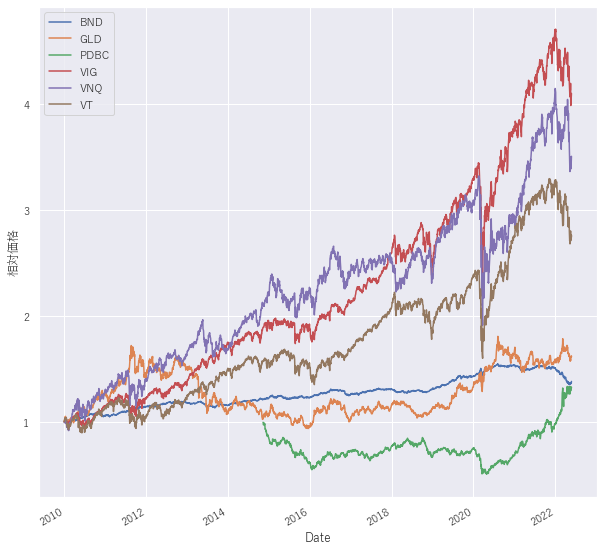

In [54]:
# 可視化
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font='Yu Gothic')

# 可視化用コード
# 価格推移
# plot_df = all_df/all_df.loc['2020-11-02',:]
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_ylabel('相対価格')

# calculate daily and annual returns of the stocks
returns_daily = data.pct_change()

simple_return =  returns_daily + 1
simple_return.iloc[0,:] = 1
#simple_return = simple_return.resample('M').sum()
simple_return = simple_return.cumprod()
simple_return.plot(figsize=(10,10),ax=ax)


<AxesSubplot:>

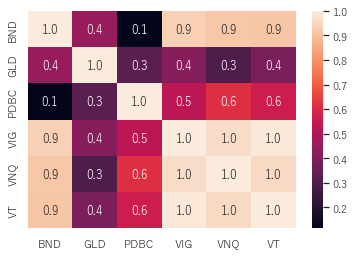

In [55]:
# 相関係数
sns.heatmap(data.corr(),annot=True, fmt="1.1f")

In [56]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.risk_models import CovarianceShrinkage
import math
import numpy as np


In [68]:
# 諸パラメータの計算
days=252 #リターン、リスクの計算期間
# mu = expected_returns.mean_historical_return(data,frequency=days) # リターンの計算
mu = expected_returns.mean_historical_return(data) # リターンの計算

# S = risk_models.sample_cov(data) # リスク：標本共分散の計算
S = risk_models.sample_cov(data)

# risks = (data.pct_change().dropna(how='all')).std() # 各株ごとの平均リスク（標準偏差）の計算
# risks = ((risks*risks)*days).apply(math.sqrt) # 指定期間での各株ごとのリスク（標準偏差）の計算

# ef = EfficientFrontier(mu, S)
# # ポートフォリオの期待リターンが目標リターン以上となる制約のもとポートフォリオの分散を最小化する
# ef.efficient_return(target_return=0.1)

# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
# ef.save_weights_to_file("weights.csv")  # saves to file
print(cleaned_weights)
ef.portfolio_performance(verbose=True)


OrderedDict([('BND', 0.50179), ('GLD', 0.03952), ('PDBC', 0.0), ('VIG', 0.45869), ('VNQ', 0.0), ('VT', 0.0)])
Expected annual return: 7.0%
Annual volatility: 7.5%
Sharpe Ratio: 0.67


(0.07017166100415764, 0.07474171826167188, 0.6712671607107814)

In [67]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

df = data
latest_prices = get_latest_prices(df)

da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.greedy_portfolio()
print("Discrete allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))

Discrete allocation: {'BND': 65, 'VIG': 31, 'GLD': 2}
Funds remaining: $19.67


In [90]:
#expected returns
#covariance matrix
e_r = expected_returns.mean_historical_return(data)
cov_matrix = CovarianceShrinkage(data).ledoit_wolf()

from pypfopt.efficient_frontier import EfficientFrontier

#border problem solution
#selectiong portfolio with better sharpe ratio
ef = EfficientFrontier(e_r, cov_matrix)
# weights = ef.max_sharpe()
# weights



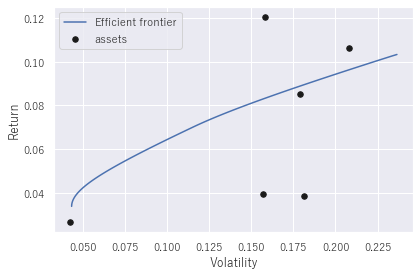

In [76]:
# from pypfopt import plotting
# ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
# ef.add_constraint(lambda w: w[0] >= 0.2)
# ef.add_constraint(lambda w: w[2] == 0.15)
# ef.add_constraint(lambda w: w[3] + w[4] <= 0.10)

# fig, ax = plt.subplots()
# plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
# plt.show()

TypeError: cannot pickle 'osqp.OSQP_results' object

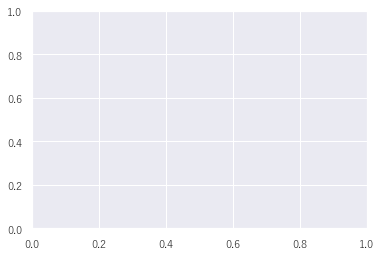

In [93]:
import copy
import osqp
from pypfopt import plotting
fig, ax = plt.subplots()
ef_max_sharpe = copy.deepcopy(ef)
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# # Find the tangency portfolio
# # ef_max_sharpe.max_sharpe()
# ret_tangent, std_tangent, _ = ef_max_sharpe.portfolio_performance()
# ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# # Generate random portfolios
# n_samples = 10000
# w = np.random.dirichlet(np.ones(ef.n_assets), n_samples)
# rets = w.dot(ef.expected_returns)
# stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
# sharpes = rets / stds
# ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# # Output
# ax.set_title("Efficient Frontier with random portfolios")
# ax.legend()
# plt.tight_layout()
# plt.savefig("ef_scatter.png", dpi=200)
# plt.show()